https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2025/02-regression/homework.md

The goal of this homework is to create a regression model for predicting the car fuel efficiency (column 'fuel_efficiency_mpg')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Use only the following columns:
columns = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']

In [3]:
df = pd.read_csv('data/car_fuel_efficiency.csv', usecols=columns)
print(df.shape)
df.head()

(9704, 5)


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


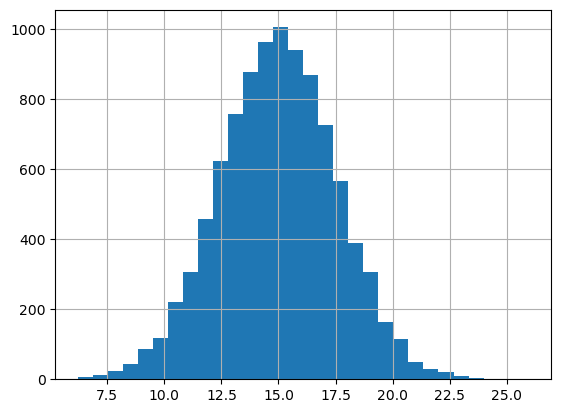

In [4]:
df['fuel_efficiency_mpg'].hist(bins=30);

The distribution looks normal

### Question 1
There's one column with missing values. What is it?

In [5]:
df.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

Ans: horsepower

### Question 2
What's the median (50% percentile) for variable 'horsepower'?

In [6]:
df['horsepower'].median()

149.0

Ans: 149

# Split the data

In [7]:
# Shuffle the dataset (the filtered one you created above), use seed 42.
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [8]:
# Split your data in train/val/test sets, with 60%/20%/20% distribution.
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - n_test - n_val
n, n_train, n_val, n_test

(9704, 5824, 1940, 1940)

In [9]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]
len(df_train), len(df_test), len(df_val)

(5824, 1940, 1940)

In [10]:
df_train.reset_index(drop=True,inplace=True)
df_val.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [11]:
y_train = df_train.pop('fuel_efficiency_mpg')
y_val = df_val.pop('fuel_efficiency_mpg')
y_test = df_test.pop('fuel_efficiency_mpg')
len(y_train), len(y_val), len(y_test)

(5824, 1940, 1940)

### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

In [12]:
def train_linear_regression(X, y):
    X = X.copy()
    ones = np.ones(len(X))
    X = np.column_stack([ones, X])
    XTX = X.T @ X
    XTX_inv = np.linalg.inv(XTX)
    temp = XTX_inv @ X.T
    w = temp @ y
    return w[0], w[1:]

In [13]:
def predict(X, w0, w):
    return w0 + X @ w

In [14]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = np.mean(se)
    return np.sqrt(mse)

In [15]:
methods = [('zeros',0), 
           ('mean', df_train['horsepower'].mean())]

for method, value in methods:
    w0, w = train_linear_regression(df_train.fillna(value), y_train)
    y_pred = predict(df_val.fillna(value), w0, w)
    print(method, rmse(y_val, y_pred).round(2))

zeros 0.52
mean 0.46


Ans: model gives better RMSE with the filling of missing values with mean value

### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?

In [16]:
def train_linear_regression_regularized(X, y, r=0.01):
    X = X.copy()
    ones = np.ones(len(X))
    X = np.column_stack([ones, X])
    XTX = X.T @ X
    XTX += r * np.eye(len(XTX))
    XTX_inv = np.linalg.inv(XTX)
    temp = XTX_inv @ X.T
    w = temp @ y
    return w[0], w[1:]

In [17]:
scores = []
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_regularized(df_train.fillna(0), y_train, r)
    y_pred = predict(df_val.fillna(0), w0, w)
    scores.append([r, rmse(y_val, y_pred).round(2)])    
df_scores = pd.DataFrame(scores, columns=['r','RMSE'])
df_scores.sort_values(['RMSE', 'r'], inplace=True)
df_scores

,r,RMSE
0,0.00,0.52
1,0.01,0.52
2,0.10,0.52
3,1.00,0.52
4,5.00,0.52
5,10.00,0.52
6,100.00,0.52


Answer: r = 0 gives the best RMSE

### Question 5

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [18]:
scores = []

n = len(df)
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - n_test - n_val

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]

    y_train = df_train.pop('fuel_efficiency_mpg')
    y_val = df_val.pop('fuel_efficiency_mpg')

    w0, w = train_linear_regression(df_train.fillna(0), y_train)
    y_pred = predict(df_val.fillna(0), w0, w)

    score = rmse(y_val, y_pred)
    scores.append(score.round(3))
    print(f"seed: {seed}, RMSE {score}")

np.std(scores).round(4)

seed: 0, RMSE 0.5206531296286018
seed: 1, RMSE 0.5213388912861504
seed: 2, RMSE 0.5228069974692388
seed: 3, RMSE 0.5159516741085217
seed: 4, RMSE 0.5109129460088697
seed: 5, RMSE 0.5283406460156541
seed: 6, RMSE 0.531391065815884
seed: 7, RMSE 0.509067038737912
seed: 8, RMSE 0.5147399129397889
seed: 9, RMSE 0.5131865908276104


np.float64(0.0069)

Ans: Standard deviation is 0.006

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

In [19]:
seed = 9
idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]
len(df_train), len(df_test)

(7764, 1940)

In [20]:
y_train = df_train.pop('fuel_efficiency_mpg')
y_test = df_test.pop('fuel_efficiency_mpg')

In [21]:
r=0.001
w0, w = train_linear_regression_regularized(df_train.fillna(0), y_train, r)

In [22]:
y_pred = predict(df_test.fillna(0), w0, w)
rmse(y_test, y_pred).round(4)

np.float64(0.5156)

Ans: RMSE on the test dataset is 0.515